# Run `folktexts` benchmark with a different data source

This notebook describes how to use the `folktexts` pipeline to run a benchmark on a different
tabular dataset (distinct from the ACS tasks provided out-of-the-box).

In this example, we have mapped 11 columns of the [Medical Expenditure Panel Survey (MEPS)](https://meps.ahrq.gov/mepsweb/index.jsp) dataset (survey panels 19, 20, and 21).

Data codebook available [at this link](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_codebook.jsp?PUFId=H192).

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import folktexts

folktexts.__version__

'0.0.22'

Define mappings for each dataset column using `ColumnToText`: each value of each
column should be mapped to a meaningful text representation.

In [2]:
from folktexts.col_to_text import ColumnToText

# AGE
meps_age_col = ColumnToText(
    "AGE",
    short_description="age",
    value_map=lambda x: f"{int(x)} years old",
)

# REGION: Census region
meps_region_col = ColumnToText(
    "REGION",
    short_description="US region",
    value_map={
        1: "Northeast",
        2: "Midwest",
        3: "South",
        4: "West",
    },
)

# SEX
meps_sex_col = ColumnToText(
    "SEX",
    short_description="sex",
    value_map={
        1: "Male",
        2: "Female",
    },
)

# MARRY / MARRY31X
meps_marital_status = ColumnToText(
    "MARRY",
    short_description="marital status",
    value_map={
        1: "Married",
        2: "Widowed",
        3: "Divorced",
        4: "Separated",
        5: "Never married",
        6: "Inapplicable - Under 16 years old",
        7: "Married during current survey round",
        8: "Widowed during current survey round",
        9: "Divorced during current survey round",
        10: "Separated during current survey round",
    },
)

# HONRDC: Honorably discharged from military
meps_education_col = ColumnToText(
    "HONRDC",
    short_description="honorably discharged status",
    value_map={
        1: "Yes, honorably discharged from military",
        2: "Not part of military or not honorably discharged",
        3: "Inapplicable - Under 16 years old",
        4: "Inapplicable - Now on active duty",
    },
)

# RTHLTH / RTHLTH31: Perceived health status
meps_health_status_col = ColumnToText(
    "RTHLTH",
    short_description="self-rated health status",
    value_map={
        1: "Excellent",
        2: "Very good",
        3: "Good",
        4: "Fair",
        5: "Poor",
        -1: "Inapplicable - Missing data",
        -7: "Inapplicable - Refused to answer",
        -8: "Inapplicable - Don't know",
    },
)

# MNHLTH / MNHLTH31: Perceived mental health status
meps_mental_health_status_col = ColumnToText(
    "MNHLTH",
    short_description="self-rated mental health status",
    value_map={
        1: "Excellent",
        2: "Very good",
        3: "Good",
        4: "Fair",
        5: "Poor",
        -1: "Inapplicable - Missing data",
        -7: "Inapplicable - Refused to answer",
        -8: "Inapplicable - Don't know",
    },
)

# POVCAT / POVCAT15: Poverty category
meps_poverty_category_col = ColumnToText(
    "POVCAT",
    short_description="poverty category",
    value_map={
        1: "Poor",
        2: "Near poor",
        3: "Low income",
        4: "Middle income",
        5: "High income",
    },
)

# INSCOV / INSCOV15: Insurance coverage
meps_insurance_coverage_col = ColumnToText(
    "INSCOV",
    short_description="insurance coverage",
    value_map={
        1: "Private insurance",
        2: "Public insurance",
        3: "Uninsured",
    },
)

# DIABDX: Diabetes diagnosis
meps_diabetes_col = ColumnToText(
    "DIABDX",
    short_description="diabetes diagnosis",
    value_map={
        1: "Yes, diagnosed with diabetes",
        2: "No, not diagnosed with diabetes",
        -1: "Inapplicable - Under 17 years old",
    },
    missing_value_fill="Inapplicable - Under 17 years old",
)

# HIBPDX: High blood pressure diagnosis
meps_high_blood_pressure_col = ColumnToText(
    "HIBPDX",
    short_description="high blood pressure diagnosis",
    value_map={
        1: "Yes, diagnosed with high blood pressure",
        2: "No, not diagnosed with high blood pressure",
        -1: "Inapplicable - Under 17 years old",
    },
    missing_value_fill="Inapplicable - Under 17 years old",
)

Define the target column mapping and the question to prompt the LLM with by instantiating a `MultipleChoiceQA` object:

In [3]:
from folktexts.qa_interface import MultipleChoiceQA, Choice

TARGET_COL = "UTILIZATION"

utilization_qa = MultipleChoiceQA(
    column=TARGET_COL,
    text="Was is this person's estimated number of doctor visits in the past year?",
    choices=(
        Choice("More than 10 doctor visits (high health-care utilization)", 1),
        Choice("10 or fewer doctor visits (low health-care utilization)", 0),
    ),
)

# UTILIZATION: Number of doctor visits
meps_utilization_col = ColumnToText(
    TARGET_COL,
    short_description="doctor visits",
    question=utilization_qa,
)

Optionally, you can define a **numeric question prompt that asks for a verbalized probability** by instantiating a `DirectNumericQA` object:

In [4]:
from folktexts.qa_interface import DirectNumericQA

utilization_numeric_qa = DirectNumericQA(
    column=TARGET_COL,
    text=(
        "What is the probability that this person has high health-care utilization? "
        "(i.e., more than 10 doctor visits per year)"
    ),
)

Define the prediction task be instantiating a `TaskMetadata` object:

In [5]:
# Helper dict to access ColumnToText objects by column name
meps_columns_map: dict[str, object] = {
    col_mapper.name: col_mapper
    for col_mapper in globals().values()
    if isinstance(col_mapper, ColumnToText)
}

In [6]:
from folktexts.task import TaskMetadata

meps_task = TaskMetadata(
    name="health-care utilization",
    description=(
        "predict whether an individual had low or high healthcare utilization "
        "in the past year by their number of doctor visits"
    ),
    features=[col.name for col in meps_columns_map.values() if col.name != TARGET_COL],
    target=TARGET_COL,
    cols_to_text=meps_columns_map,
    sensitive_attribute="SEX",
    multiple_choice_qa=utilization_qa,
    direct_numeric_qa=utilization_numeric_qa,
)

**Set** whether to use numeric risk prompting or the default multiple-choice Q&A prompting:

In [7]:
meps_task.use_numeric_qa = False
# meps_task.use_numeric_qa = True

Load MEPS data and instantiate the `Dataset` object:

In [8]:
from folktexts.dataset import Dataset

DATA_PATH = Path(folktexts.__file__).parent.parent / "notebooks" / "data" / "meps.csv"
meps_df = pd.read_csv(DATA_PATH)

dataset = Dataset(
    data=meps_df,
    task=meps_task,
    test_size=0.4,
    val_size=0,
    subsampling=0.1,   # NOTE: Optional, for faster but noisier results!
)

**Optionally,** you can subsample the data to get faster but noisier results, with:
```py
dataset.subsample(0.1)  # Keeps only 10% of the data
```

Load huggingface LLM:

**Note:** Update `MODEL_NAME_OR_PATH` as needed.

In [9]:
MODEL_NAME_OR_PATH = "meta-llama/Meta-Llama-3-8B"

In [10]:
from folktexts.classifier import TransformersLLMClassifier
from folktexts.llm_utils import load_model_tokenizer

model, tokenizer = load_model_tokenizer(MODEL_NAME_OR_PATH)

llm_clf = TransformersLLMClassifier(
    model=model,
    tokenizer=tokenizer,
    task=meps_task,
    batch_size=20,
    context_length=800,
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Example LLM prompt for this task:

In [11]:
X_sample, _y_sample = dataset.sample_n_train_examples(n=1)
print(llm_clf.encode_row(X_sample.iloc[0], question=llm_clf.task.question))

The following data corresponds to a survey respondent. The survey was conducted among US residents in 2018. Please answer the question based on the information provided. The data provided is enough to reach an approximate answer.

Information:
- The age is: 37 years old.
- The US region is: West.
- The sex is: Female.
- The marital status is: Never married.
- The honorably discharged status is: Not part of military or not honorably discharged.
- The self-rated health status is: Good.
- The self-rated mental health status is: Good.
- The poverty category is: Poor.
- The insurance coverage is: Private insurance.
- The diabetes diagnosis is: No, not diagnosed with diabetes.
- The high blood pressure diagnosis is: No, not diagnosed with high blood pressure.

Question: Was is this person's estimated number of doctor visits in the past year?
A. More than 10 doctor visits (high health-care utilization).
B. 10 or fewer doctor visits (low health-care utilization).
Answer:


### Run benchmark on MEPS data

In [12]:
from folktexts.benchmark import BenchmarkConfig, Benchmark
bench = Benchmark(llm_clf=llm_clf, dataset=dataset)

In [13]:
%%time
bench.run(results_root_dir=".")

Computing risk estimates:   0%|          | 0/99 [00:00<?, ?it/s]

We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


CPU times: user 2min 45s, sys: 5.43 s, total: 2min 51s
Wall time: 2min 50s


{'threshold': 0.5,
 'n_samples': 1963,
 'n_positives': 354,
 'n_negatives': 1609,
 'model_name': 'Meta-Llama-3-8B',
 'accuracy': 0.630667345899134,
 'tpr': 0.7033898305084746,
 'fnr': 0.2966101694915254,
 'fpr': 0.3853325046612803,
 'tnr': 0.6146674953387197,
 'balanced_accuracy': 0.6590286629235971,
 'precision': 0.286536248561565,
 'ppr': 0.44268976057055526,
 'log_loss': 0.6640880361799258,
 'brier_score_loss': 0.23555848017340178,
 'fnr_ratio': 0.7005952380952382,
 'fnr_diff': 0.1007343124165554,
 'fpr_ratio': 0.9499246987951807,
 'fpr_diff': 0.019768133174791924,
 'ppr_ratio': 0.9785014080325124,
 'ppr_diff': 0.009620674692892017,
 'precision_ratio': 0.7380730854374539,
 'precision_diff': 0.086496795041585,
 'tpr_ratio': 0.8681980959035723,
 'tpr_diff': 0.1007343124165554,
 'balanced_accuracy_ratio': 0.9408797810568554,
 'balanced_accuracy_diff': 0.04048308962088176,
 'tnr_ratio': 0.968370986920333,
 'tnr_diff': 0.01976813317479187,
 'accuracy_ratio': 0.9913632326092872,
 'accurac

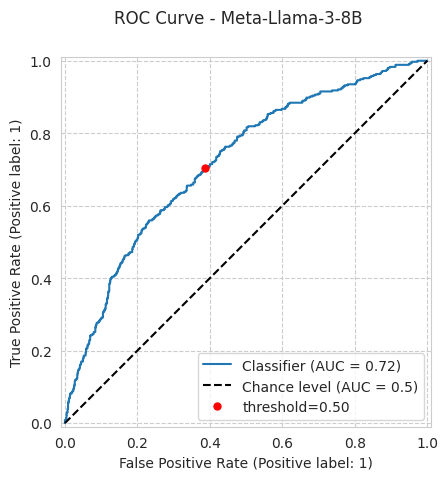

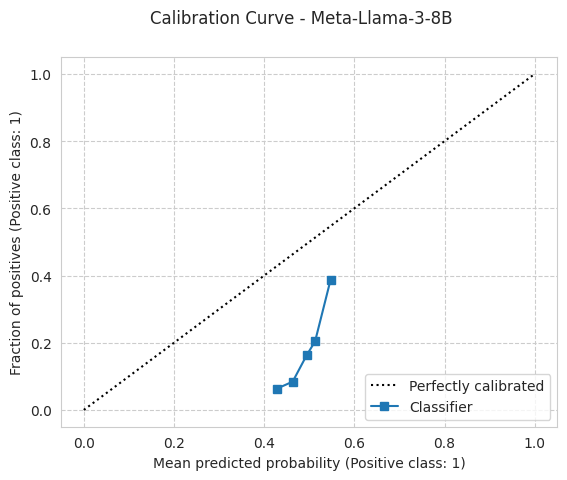

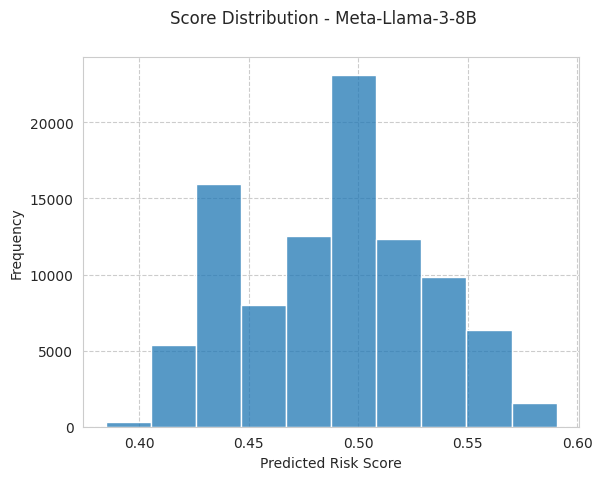

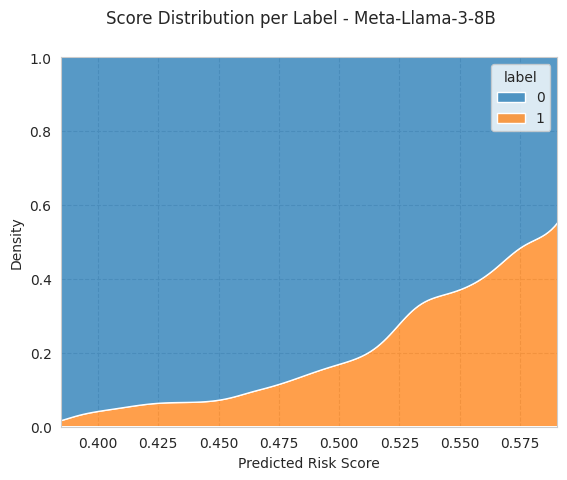

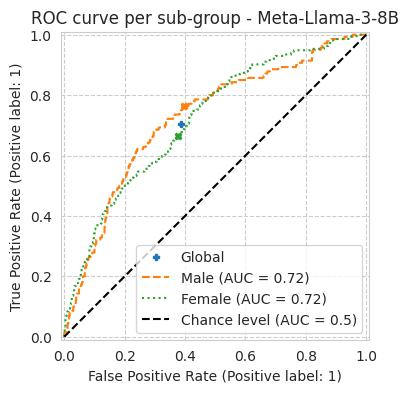

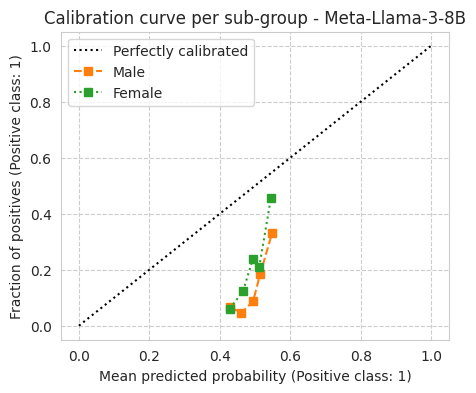

In [14]:
bench.plot_results();

In [15]:
bench.results

{'threshold': 0.5,
 'n_samples': 1963,
 'n_positives': 354,
 'n_negatives': 1609,
 'model_name': 'Meta-Llama-3-8B',
 'accuracy': 0.630667345899134,
 'tpr': 0.7033898305084746,
 'fnr': 0.2966101694915254,
 'fpr': 0.3853325046612803,
 'tnr': 0.6146674953387197,
 'balanced_accuracy': 0.6590286629235971,
 'precision': 0.286536248561565,
 'ppr': 0.44268976057055526,
 'log_loss': 0.6640880361799258,
 'brier_score_loss': 0.23555848017340178,
 'fnr_ratio': 0.7005952380952382,
 'fnr_diff': 0.1007343124165554,
 'fpr_ratio': 0.9499246987951807,
 'fpr_diff': 0.019768133174791924,
 'ppr_ratio': 0.9785014080325124,
 'ppr_diff': 0.009620674692892017,
 'precision_ratio': 0.7380730854374539,
 'precision_diff': 0.086496795041585,
 'tpr_ratio': 0.8681980959035723,
 'tpr_diff': 0.1007343124165554,
 'balanced_accuracy_ratio': 0.9408797810568554,
 'balanced_accuracy_diff': 0.04048308962088176,
 'tnr_ratio': 0.968370986920333,
 'tnr_diff': 0.01976813317479187,
 'accuracy_ratio': 0.9913632326092872,
 'accurac

---